Clustering and classification for features extracted from tiles modified with StainNet.

---
# 0. - Imports and paths

In [2]:
import os
import pandas as pd
import matplotlib.font_manager as fm
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from PIL import Image, ImageDraw
import numpy as np
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.cluster import FeatureAgglomeration
from sklearn.decomposition import PCA#, TruncatedSVD
#import umap
import umap.umap_ as umap
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D

/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.chdir("/disk2/user/gabgam/work/gigi_env/the_project/4_clustering_and_classification/")
print(os.getcwd())

/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification


In [4]:
# Fetch DM Sans font file from https://github.com/google/fonts/blob/main/ofl/dmsans/DMSans%5Bopsz%2Cwght%5D.ttf or, better, https://fonts.google.com/specimen/DM+Sans
font_path = "../fonts/static/DMSans-Medium.ttf" 

# Add font to matplotlib
try:
    fm.fontManager.addfont(font_path)
    plt.rcParams['font.family'] = 'DM Sans'
except RuntimeError as e:
    print(f"Failed to load font: {e}")

In [5]:
model = "kimianet"

In [6]:
# WIDTH = 1000
# PATH_TO_MERGED_PICKLES = f"output/{model}/satac_C1_v3_allspots_&_visium_2022_FF_WG_10X_img_not_changed_allspots/"
# COMPARISON = "satac_C1_v3_allspots_&_visium_2022_FF_WG_10X_img_not_changed_allspots"

# if WIDTH:
#     SELECTED_PICKLE_100um = f'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_stainNET_width{WIDTH}.pickle'
#     SELECTED_PICKLE_68um = f'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_stainNET_width{WIDTH}.pickle'
# else:
#     SELECTED_PICKLE_100um = 'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_stainNET.pickle'
#     SELECTED_PICKLE_68um = 'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_stainNET.pickle'

In [7]:
WIDTH = 1000
PATH_TO_MERGED_PICKLES = f"output/{model}/satac_C1_v3_allspots_&_visium_FFPE_dcis_idc_10X_img_not_changed_allspots/"
COMPARISON = "satac_C1_v3_allspots_&_visium_FFPE_dcis_idc_10X_img_not_changed_allspots"

if WIDTH:
    SELECTED_PICKLE_100um = f'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_stainNET_width{WIDTH}.pickle'
    SELECTED_PICKLE_68um = f'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_stainNET_width{WIDTH}.pickle'
else:
    SELECTED_PICKLE_100um = 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_stainNET.pickle'
    SELECTED_PICKLE_68um = 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_stainNET.pickle'

In [8]:
# path to the target image
PATH_TO_REFERENCE = "../2_image_normalisation/reference_images/reference_full.jpeg"
# `TARGET_IS_<filename>`
TARGET_IS = "target_is_reference_full"

Defining the path to the figures.

In [9]:
if WIDTH:
    PATH_TO_FIGURES = f"figures/{model}/{COMPARISON}_width{WIDTH}"
else:
    PATH_TO_FIGURES = f"figures/{model}/{COMPARISON}"
    
os.makedirs(PATH_TO_FIGURES, exist_ok=True)

# 1. - Importing the extracted features

First of all, let's see all the MERGED `.pickle` files inside the folder of the saved features.

In [10]:
if WIDTH:
    all_pickle_names = [i for i in os.listdir(PATH_TO_MERGED_PICKLES) if i.endswith(f'{WIDTH}.pickle')]
else:
    all_pickle_names = [i for i in os.listdir(PATH_TO_MERGED_PICKLES) if i.endswith('.pickle')]

print(f"{len(all_pickle_names)} .pickle files inside the folder.\n")
print(all_pickle_names)

8 .pickle files inside the folder.

['MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_ORIGINAL WSI_width1000.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_fromWSI_histomicsTK_macenko_nomasking_width1000.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_histomicsTK_macenko_nomasking_width1000.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_stainNET_width1000.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_ORIGINAL WSI_width1000.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_fromWSI_histomicsTK_mac

And let's choose the first file to visualise and extract the normalisation name from it.

In [11]:
TILE_SIZE = 100
SPOT_SIZE = 68

# Extractin the normalisation name from just one of it. They are the same in the end
# Find the pattern matching "<number>um_", the normalisation name is after it.
match = re.search(r"\d+um_", SELECTED_PICKLE_100um)

if match:
    # Extract everything after "<number>um_", remove the file type name and replace eventually present underscores with spaces.
    normalisation_name = SELECTED_PICKLE_100um.split(match.group())[-1].split(".")[0].replace("_", " ")
else:
    print("Wrong file inserted, no normalisation name found.")

print(normalisation_name)

stainNET width1000


In [12]:
from utils_clust_n_class import load_pickle_as_df

merged_selected_pickle_df_100um = load_pickle_as_df(os.path.join(PATH_TO_MERGED_PICKLES, SELECTED_PICKLE_100um))
merged_selected_pickle_df_100um

0         1     \
AAACAAGGGATCAAAT_row31_col71_100um_stainNET_Sta...  0.069129  0.179094   
AAACAGCAGTCTGCTA_row46_col32_100um_stainNET_Sta...  0.029451  0.186680   
AAACATTCGGGATTCT_row46_col22_100um_stainNET_Sta...  0.042763  0.160322   
AAACCTGGCACACCCT_row21_col33_100um_stainNET_Sta...  0.070244  0.174395   
AAACGCGGCGAAAGTA_row38_col90_100um_stainNET_Sta...  0.047160  0.144156   
...                                                      ...       ...   
GCCCTGAGGATGGGCT-1_row68_col74_100um_stainNET       0.054879  0.176586   
CGGGCGATGGATCACG-1_row69_col75_100um_stainNET       0.059839  0.149598   
TGCGGACTTGACTCCG-1_row68_col76_100um_stainNET       0.061282  0.198132   
TCGCTGCCAATGCTGT-1_row68_col80_100um_stainNET       0.077956  0.151921   
GGTGTAGGTAAGTAAA-1_row70_col50_100um_stainNET       0.050044  0.166072   

                                                        2         3     \
AAACAAGGGATCAAAT_row31_col71_100um_stainNET_Sta...  0.240163 -0.517084   
AAACAGCAGTCTGCTA_row46_col32_100um_stainNET_Sta...  0.278758 -0.654921   
AAACATTCGGGATTCT_row46_col22_100um_stainNET_Sta...  0.217126 -0.617783   
AAACCTGGCACACCCT_row21_col33_100um_stainNET_Sta...  0.237643 -0.533363   
AAACGCGGCGAAAGTA_row38_col90_100um_stainNET_Sta...  0.231554 -0.595404   
...                                                      ...       ...   
GCCCTGAGGATGGGCT-1_row68_col74_100um_stainNET       0.307514 -0.494506   
CGGGCGATGGATCACG-1_row69_col75_100um_stainNET       0.221968 -0.471271   
TGCGGACTTGACTCCG-1_row68_col76_100um_stainNET       0.313084 -0.478029   
TCGCTGCCAATGCTGT-1_row68_col80_100um_stainNET       0.239783 -0.478191   
GGTGTAGGTAAGTAAA-1_row70_col50_100um_stainNET       0.262183 -0.457668   

                                                        4         5     \
AAACAAGGGATCAAAT_row31_col71_100um_stainNET_Sta...  0.075426 -1.150454   
AAACAGCAGTCTGCTA_row46_col32_100um_stainNET_Sta...  0.154876 -1.126532   
AAACATTCGGGATTCT_row46_col22_100um_stainNET_Sta...  0.163615 -1.248097   
AAACCTGGCACACCCT_row21_col33_100um_stainNET_Sta...  0.088822 -1.212256   
AAACGCGGCGAAAGTA_row38_col90_100um_stainNET_Sta...  0.140853 -1.542843   
...                                                      ...       ...   
GCCCTGAGGATGGGCT-1_row68_col74_100um_stainNET       0.031446 -0.687444   
CGGGCGATGGATCACG-1_row69_col75_100um_stainNET       0.271926 -1.016354   
TGCGGACTTGACTCCG-1_row68_col76_100um_stainNET      -0.197257 -0.626863   
TCGCTGCCAATGCTGT-1_row68_col80_100um_stainNET       0.184753 -1.207619   
GGTGTAGGTAAGTAAA-1_row70_col50_100um_stainNET       0.592170 -0.472070   

                                                        6         7     \
AAACAAGGGATCAAAT_row31_col71_100um_stainNET_Sta...  0.065566  0.157922   
AAACAGCAGTCTGCTA_row46_col32_100um_stainNET_Sta...  0.071652  0.156908   
AAACATTCGGGATTCT_row46_col22_100um_stainNET_Sta...  0.079193  0.157304   
AAACCTGGCACACCCT_row21_col33_100um_stainNET_Sta...  0.067947  0.158101   
AAACGCGGCGAAAGTA_row38_col90_100um_stainNET_Sta...  0.085285  0.158714   
...                                                      ...       ...   
GCCCTGAGGATGGGCT-1_row68_col74_100um_stainNET       0.052909  0.164908   
CGGGCGATGGATCACG-1_row69_col75_100um_stainNET       0.041123  0.164078   
TGCGGACTTGACTCCG-1_row68_col76_100um_stainNET       0.055583  0.166134   
TCGCTGCCAATGCTGT-1_row68_col80_100um_stainNET       0.035243  0.166266   
GGTGTAGGTAAGTAAA-1_row70_col50_100um_stainNET       0.042963  0.162502   

                                                        8         9     ...  \
AAACAAGGGATCAAAT_row31_col71_100um_stainNET_Sta... -0.316814 -0.112180  ...   
AAACAGCAGTCTGCTA_row46_col32_100um_stainNET_Sta... -0.332325 -0.136201  ...   
AAACATTCGGGATTCT_row46_col22_100um_stainNET_Sta... -0.338214 -0.120503  ...   
AAACCTGGCACACCCT_row21_col33_100um_stainNET_Sta... -0.232149 -0.111128  ...   
AAACGCGGCGAAAGTA_row38_col90_100um_stainNET_Sta... -0.455882 -0.121024  ...   
...                       

In [13]:
from utils_clust_n_class import load_pickle_as_df

merged_selected_pickle_df_68um = load_pickle_as_df(os.path.join(PATH_TO_MERGED_PICKLES, SELECTED_PICKLE_68um))
merged_selected_pickle_df_68um

0         1         2     \
CCGACCACCCTACGCG_row0_col0_68um_stainNET      0.041450  0.186968  0.302238   
AAGCCATAGTCGCGAC_row1_col1_68um_stainNET      0.036955  0.185088  0.246188   
TTGGGCGGACCGAAGC_row0_col2_68um_stainNET      0.042953  0.178041  0.241984   
AGTAAAGCGCATAATC_row1_col3_68um_stainNET      0.045233  0.191462  0.270749   
CGACTCCGCCGATCAA_row0_col4_68um_stainNET      0.035894  0.203628  0.259230   
...                                                ...       ...       ...   
GCCCTGAGGATGGGCT-1_row68_col74_68um_stainNET  0.031327  0.191197  0.270399   
CGGGCGATGGATCACG-1_row69_col75_68um_stainNET  0.037582  0.169241  0.188182   
TGCGGACTTGACTCCG-1_row68_col76_68um_stainNET  0.025395  0.223995  0.262452   
TCGCTGCCAATGCTGT-1_row68_col80_68um_stainNET  0.054263  0.166490  0.205084   
GGTGTAGGTAAGTAAA-1_row70_col50_68um_stainNET  0.035253  0.173467  0.168331   

                                                  3         4         5     \
CCGACCACCCTACGCG_row0_col0_68um_stainNET     -0.614580 -0.180294 -0.476309   
AAGCCATAGTCGCGAC_row1_col1_68um_stainNET     -0.614177 -0.081180 -0.832240   
TTGGGCGGACCGAAGC_row0_col2_68um_stainNET     -0.595310 -0.191631 -0.788343   
AGTAAAGCGCATAATC_row1_col3_68um_stainNET     -0.619879 -0.096255 -0.569048   
CGACTCCGCCGATCAA_row0_col4_68um_stainNET     -0.605938 -0.127285 -0.487242   
...                                                ...       ...       ...   
GCCCTGAGGATGGGCT-1_row68_col74_68um_stainNET -0.501214 -0.048239 -0.414437   
CGGGCGATGGATCACG-1_row69_col75_68um_stainNET -0.482924  0.058051 -0.646705   
TGCGGACTTGACTCCG-1_row68_col76_68um_stainNET -0.506558 -0.404479 -0.326701   
TCGCTGCCAATGCTGT-1_row68_col80_68um_stainNET -0.479027  0.022822 -0.933203   
GGTGTAGGTAAGTAAA-1_row70_col50_68um_stainNET -0.479436  0.249056 -0.506503   

                                                  6         7         8     \
CCGACCACCCTACGCG_row0_col0_68um_stainNET      0.060850  0.159760 -0.209760   
AAGCCATAGTCGCGAC_row1_col1_68um_stainNET      0.066522  0.158992 -0.282463   
TTGGGCGGACCGAAGC_row0_col2_68um_stainNET      0.062971  0.160989 -0.268755   
AGTAAAGCGCATAATC_row1_col3_68um_stainNET      0.060525  0.159527 -0.192425   
CGACTCCGCCGATCAA_row0_col4_68um_stainNET      0.056855  0.158790 -0.170510   
...                                                ...       ...       ...   
GCCCTGAGGATGGGCT-1_row68_col74_68um_stainNET  0.041609  0.164547 -0.223546   
CGGGCGATGGATCACG-1_row69_col75_68um_stainNET  0.043071  0.166194 -0.327803   
TGCGGACTTGACTCCG-1_row68_col76_68um_stainNET  0.047188  0.165124 -0.372789   
TCGCTGCCAATGCTGT-1_row68_col80_68um_stainNET  0.035959  0.168985 -0.471175   
GGTGTAGGTAAGTAAA-1_row70_col50_68um_stainNET  0.041982  0.165021 -0.149663   

                                                  9     ...      1014  \
CCGACCACCCTACGCG_row0_col0_68um_stainNET     -0.065794  ...  0.545407   
AAGCCATAGTCGCGAC_row1_col1_68um_stainNET     -0.092996  ...  0.525898   
TTGGGCGGACCGAAGC_row0_col2_68um_stainNET     -0.051803  ...  0.382740   
AGTAAAGCGCATAATC_row1_col3_68um_stainNET     -0.076972  ...  0.591507   
CGACTCCGCCGATCAA_row0_col4_68um_stainNET     -0.065945  ...  0.357464   
...                                                ...  ...       ...   
GCCCTGAGGATGGGCT-1_row68_col74_68um_stainNET -0.059849  ...  0.374721   
CGGGCGATGGATCACG-1_row69_col75_68um_stainNET -0.091122  ...  0.286222   
TGCGGACTTGACTCCG-1_row68_col76_68um_stainNET -0.026584  ... -0.071484   
TCGCTGCCAATGCTGT-1_row68_col80_68um_stainNET -0.121162  ...  0.112880   
GGTGTAGGTAAGTAAA-1_row70_col50_68um_stainNET -0.114945  ...  0.288423   

                                                  1015      1016      1017  \
CCGACCACCCTACGCG_row0_col0_68um_stainNET      0.450391  1.583564  0.773874   
AAGCCATAGTCGCGAC_row1_col1_68um_stainNET      0.547166  1.290477  0.743424   
TTGGGCGGACCGAAGC_row0_col2_68um_stainNET      0.555916  1.399050  0.675426   
AGTAAAGCGCATAATC_row1_col3_68um_stainNET      0.55

# 2. - Dimensionality reduction

Let's plot the cumulative variance explained by the most important components.

## 2.1 - For 100 μm tiles

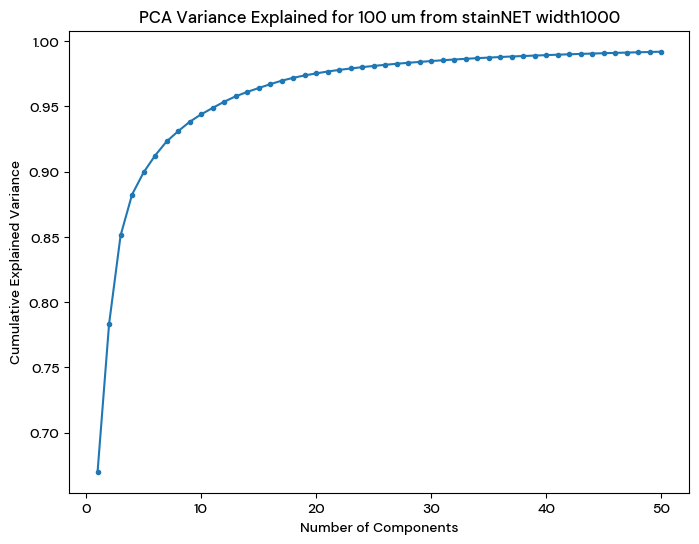

In [14]:
from utils_clust_n_class import pca_cumulative_variance_plot

plot = pca_cumulative_variance_plot(merged_selected_pickle_df_100um, normalisation_name, TILE_SIZE)
plot.show()

Then let's have a quick visualisation of the PCA, UMAP and tSNE plots.

/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')


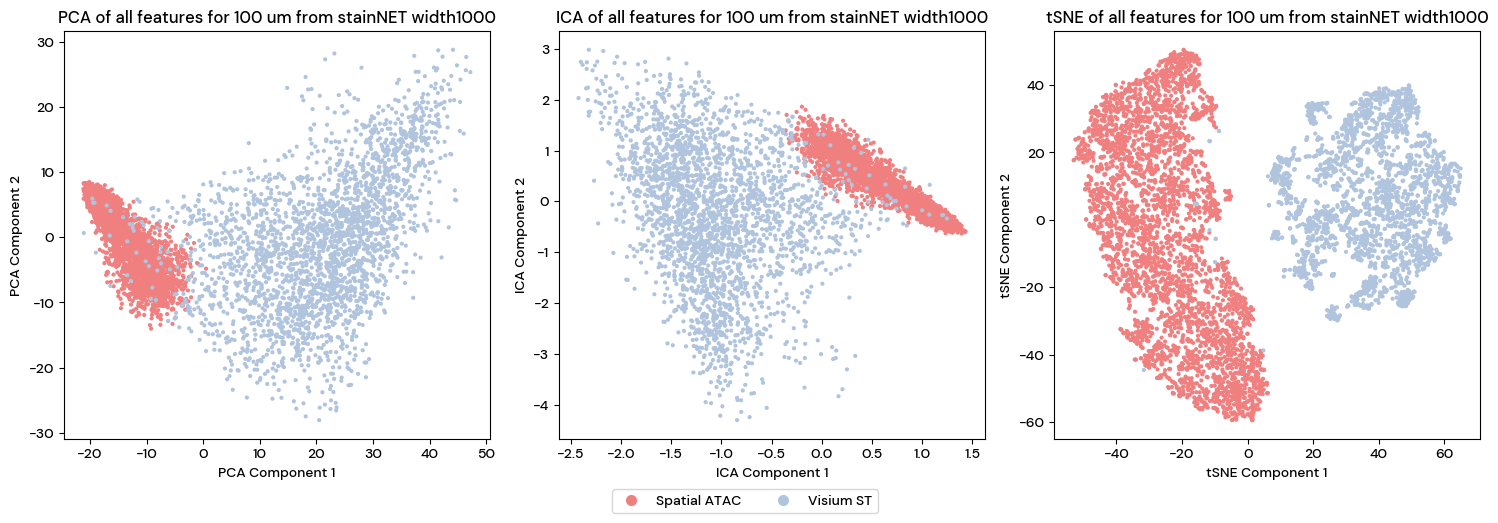

In [15]:
from utils_clust_n_class import all_dim_red

COLORS_FOR_SPATIALS = {"Spatial ATAC": "lightcoral", "Visium ST": "lightsteelblue"}

plot_100, dim_red_results_100 =  all_dim_red(merged_selected_pickle_df_100um, normalisation_name, COLORS_FOR_SPATIALS, TILE_SIZE, selected_methods = ["PCA", "ICA", "tSNE"])
plot_100.show()

In [16]:
plot_100.savefig(os.path.join(PATH_TO_FIGURES, f"plot_all_dimensionality_reductions_{TILE_SIZE}um_{normalisation_name.replace(' ', '_')}.pdf"),
                format="PDF", bbox_inches='tight')

So, we can say that the normalisation is necessary.

---

## 2.2 - For 68 μm tiles

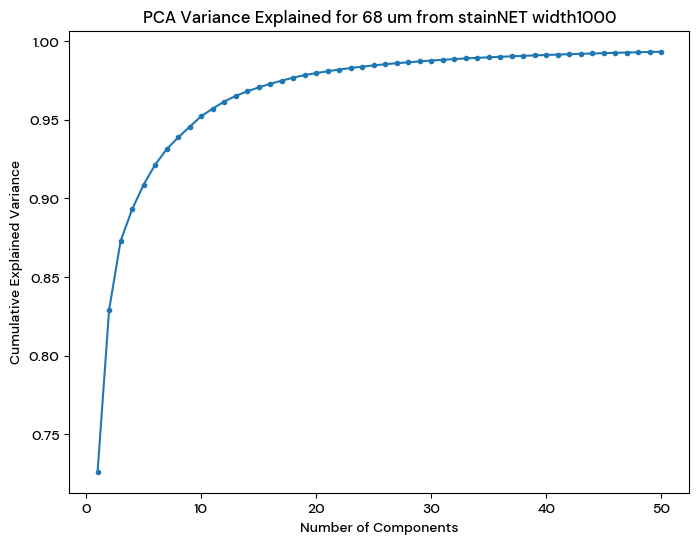

In [17]:
from utils_clust_n_class import pca_cumulative_variance_plot

plot = pca_cumulative_variance_plot(merged_selected_pickle_df_68um, normalisation_name, SPOT_SIZE)
plot.show()

Then let's have a quick visualisation of the PCA, UMAP and tSNE plots.

/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')


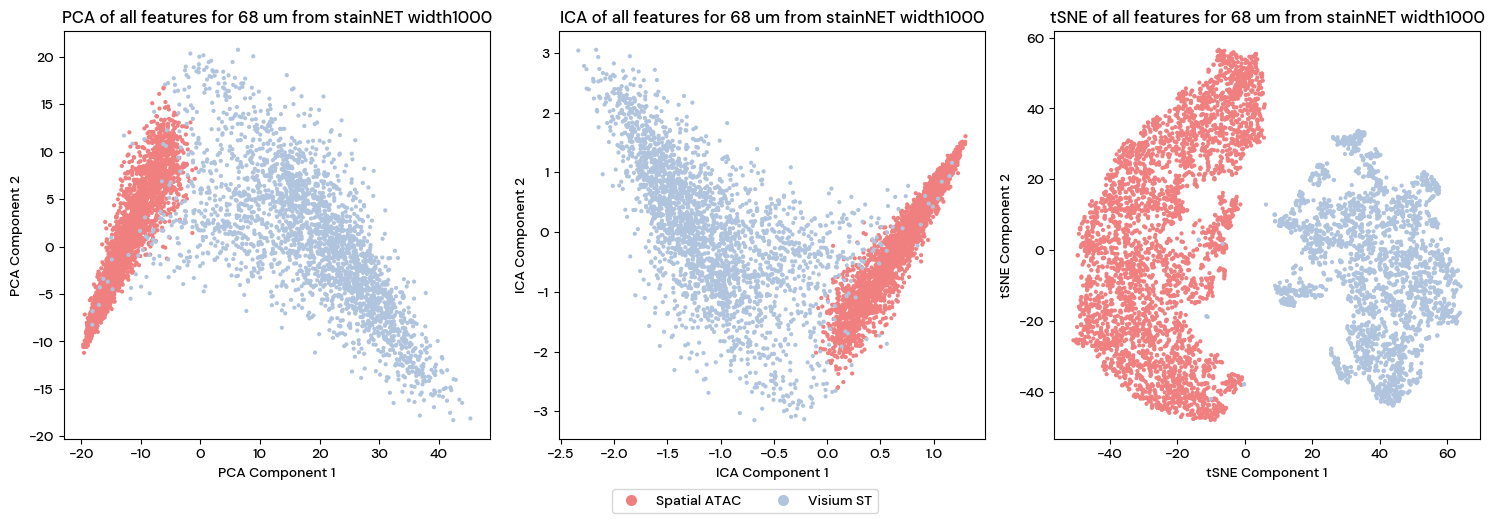

In [18]:
from utils_clust_n_class import all_dim_red

COLORS_FOR_SPATIALS = {"Spatial ATAC": "lightcoral", "Visium ST": "lightsteelblue"}

plot_68, dim_red_results_68 =  all_dim_red(merged_selected_pickle_df_68um, normalisation_name, COLORS_FOR_SPATIALS, SPOT_SIZE, selected_methods = ["PCA", "ICA", "tSNE"])
plot_68.show()

In [19]:
plot_68.savefig(os.path.join(PATH_TO_FIGURES, f"plot_all_dimensionality_reductions_{SPOT_SIZE}um_{normalisation_name.replace(' ', '_')}.pdf"), 
                format="PDF", bbox_inches='tight')

So, we can say that the normalisation is necessary.

---

# 3. - Clustering

In [19]:
dim_red_results_100["PCA"]

array([[ 15.164139 ,   0.3396054],
       [ 24.939608 ,   0.8846833],
       [ 22.670471 ,  -1.005948 ],
       ...,
       [-19.737915 ,  -7.088905 ],
       [-25.771906 ,  -2.373234 ],
       [-17.070284 , -13.842454 ]], dtype=float32)

/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/tmp/ipykernel_294246/1340331449.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


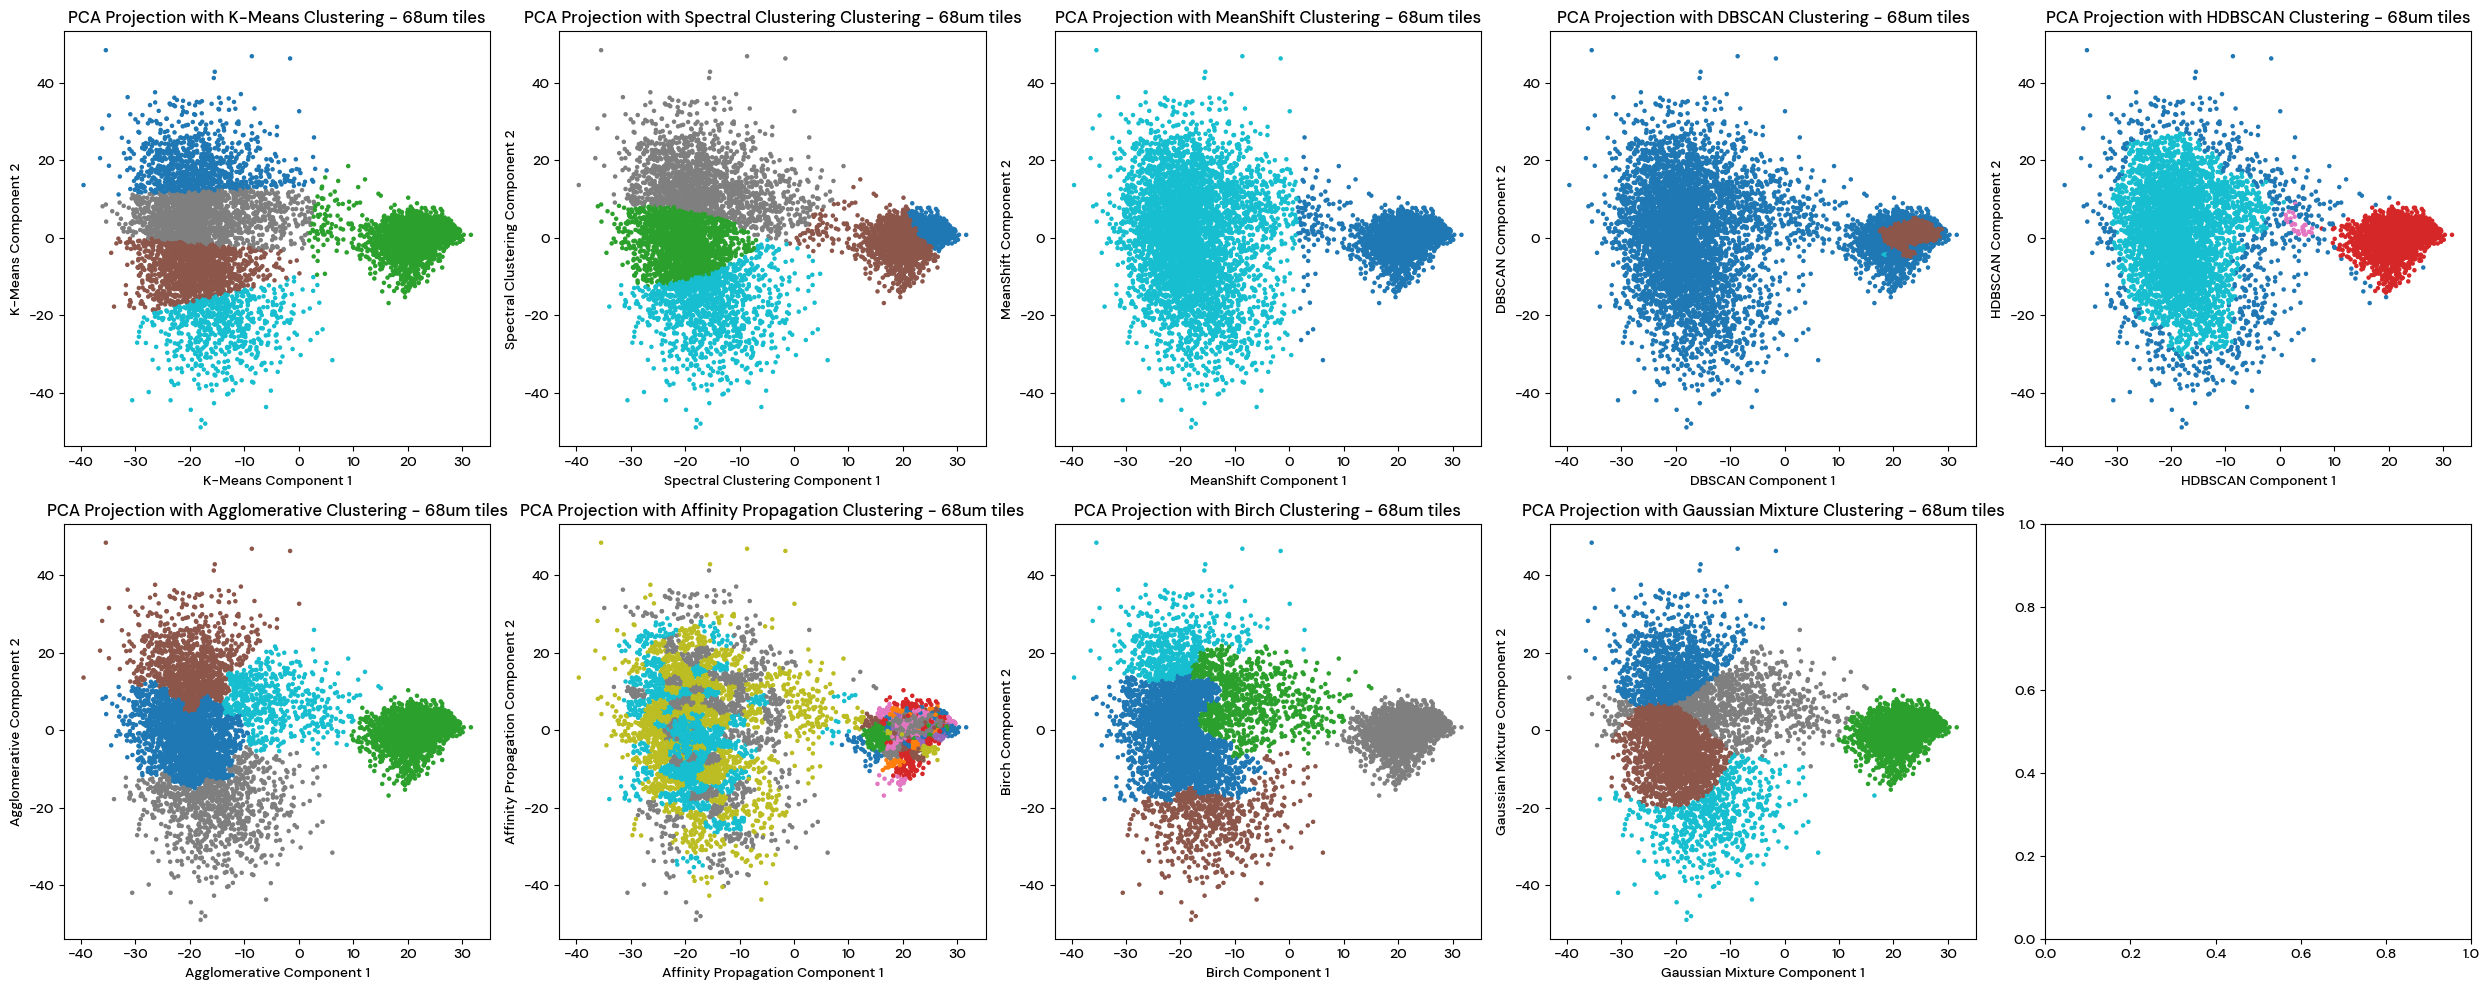

/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/tmp/ipykernel_294246/1340331449.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


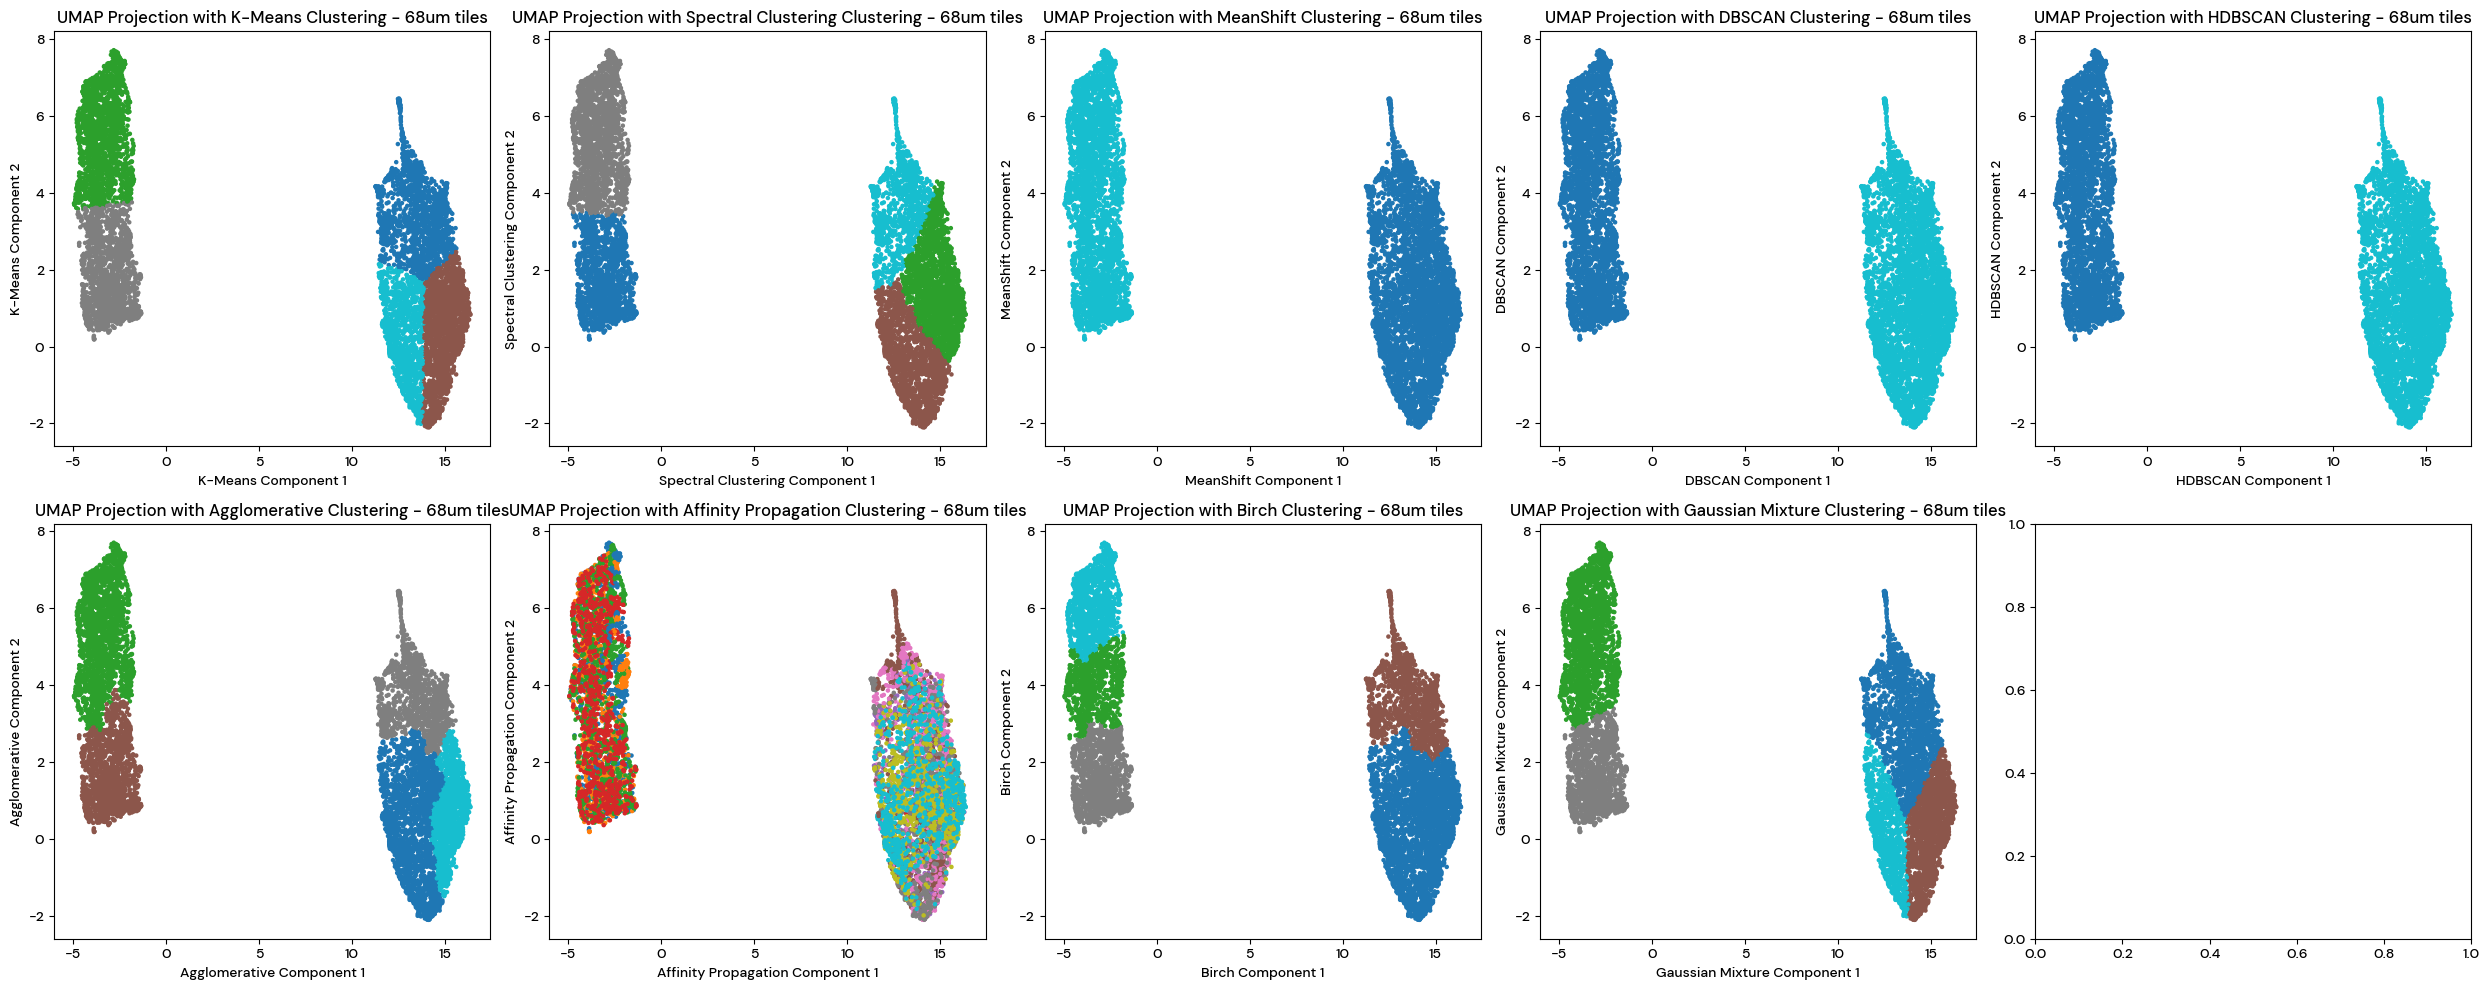

/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/tmp/ipykernel_294246/1340331449.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


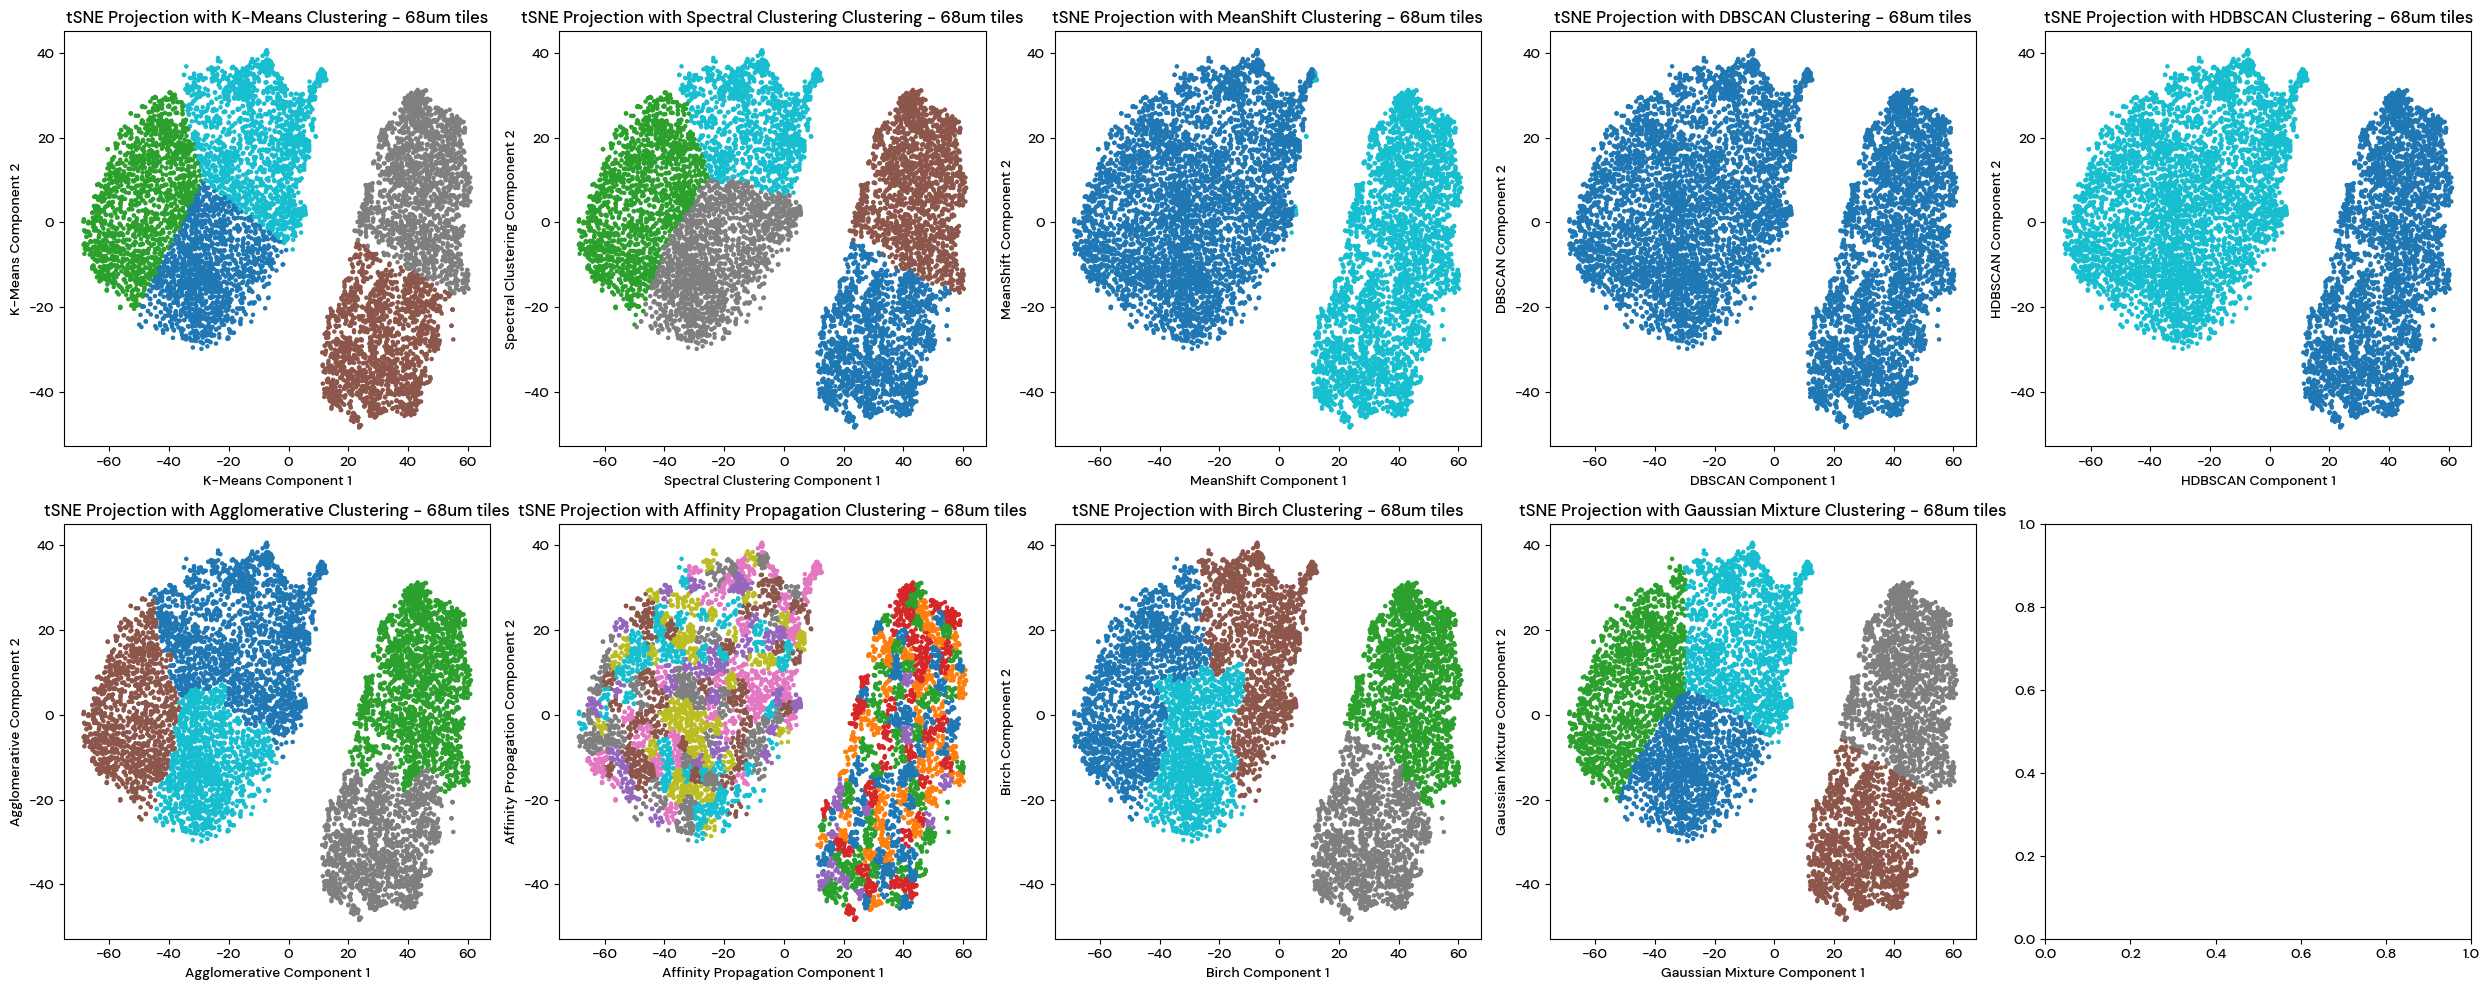

In [20]:
import math
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, HDBSCAN, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation, Birch
from sklearn.mixture import GaussianMixture


clustering_methods = [
    ("K-Means", KMeans(n_clusters=5, random_state=123)),
    ("Spectral Clustering", SpectralClustering(n_clusters=5, affinity='nearest_neighbors', n_neighbors=10, 
                                               eigen_solver='arpack', random_state=123)),
    ("MeanShift", MeanShift()),  # bandwidth will be estimated later
    ("DBSCAN", DBSCAN(eps=0.5, min_samples=20)),
    ("HDBSCAN", HDBSCAN(min_cluster_size=20)),
    ("Agglomerative", AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')),
    ("Affinity Propagation", AffinityPropagation(preference=-50)),  # Adjust preference as needed
    ("Birch", Birch(threshold=0.5, n_clusters=5)),  # Adjust threshold as needed
    ("Gaussian Mixture", GaussianMixture(n_components=5, random_state=123))
]

n_methods = len(clustering_methods)
rows = 2
cols = math.ceil(n_methods / rows)

for tech in dim_red_results_100.keys():
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), constrained_layout=True)
    
    for i, (method_name, model) in enumerate(clustering_methods):
        # Estimate bandwidth if using MeanShift
        if method_name == "MeanShift":
            est_band = estimate_bandwidth(dim_red_results_100[tech])
            model.set_params(bandwidth=est_band)
        
        

        # Compute row and col indices
        row, col = divmod(i, cols)
        
        # Fit the clustering model and predict labels
        cluster_labels = model.fit_predict(dim_red_results_100[tech])
        
        # Plot in the appropriate subplot
        ax = axes[row, col]  # Access subplot by row and column
        scatter = ax.scatter(dim_red_results_100[tech][:, 0], dim_red_results_100[tech][:, 1], c=cluster_labels, s=5, cmap='tab10')
        ax.set_title(f"{tech} Projection with {method_name} Clustering - 68um tiles")
        ax.set_xlabel(f'{method_name} Component 1')
        ax.set_ylabel(f'{method_name} Component 2')
    
    plt.tight_layout()
    plt.show()

KeyboardInterrupt: 

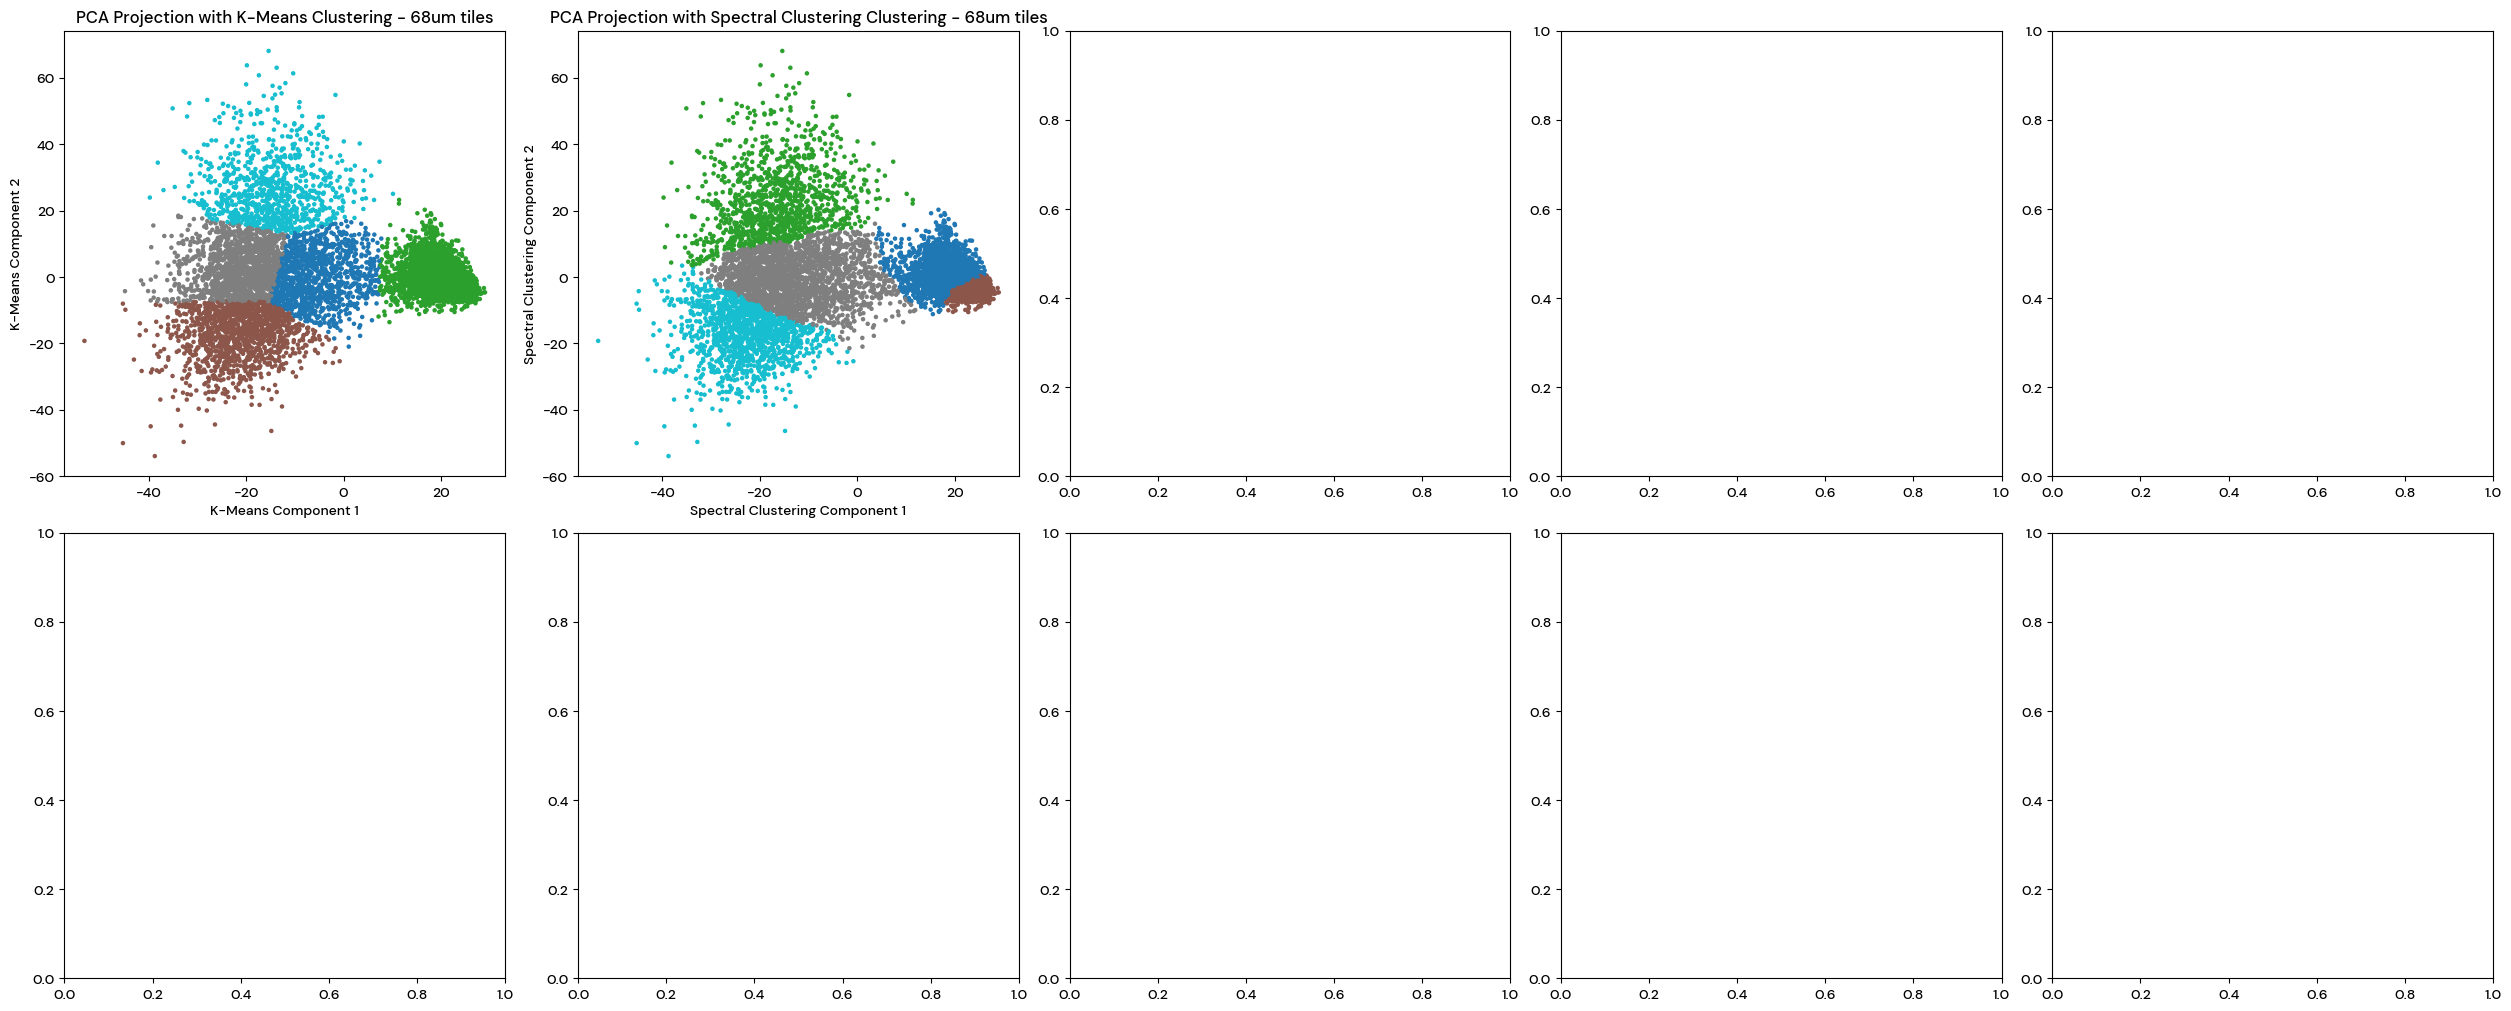

In [21]:
import math
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, HDBSCAN, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation, Birch
from sklearn.mixture import GaussianMixture


clustering_methods = [
    ("K-Means", KMeans(n_clusters=5, random_state=123)),
    ("Spectral Clustering", SpectralClustering(n_clusters=5, affinity='nearest_neighbors', n_neighbors=10, 
                                               eigen_solver='arpack', random_state=123)),
    ("MeanShift", MeanShift()),  # bandwidth will be estimated later
    ("DBSCAN", DBSCAN(eps=0.5, min_samples=20)),
    ("HDBSCAN", HDBSCAN(min_cluster_size=20)),
    ("Agglomerative", AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')),
    ("Affinity Propagation", AffinityPropagation(preference=-50)),  # Adjust preference as needed
    ("Birch", Birch(threshold=0.5, n_clusters=5)),  # Adjust threshold as needed
    ("Gaussian Mixture", GaussianMixture(n_components=5, random_state=123))
]

n_methods = len(clustering_methods)
rows = 2
cols = math.ceil(n_methods / rows)

for tech in dim_red_results_68.keys():
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), constrained_layout=True)
    
    for i, (method_name, model) in enumerate(clustering_methods):
        # Estimate bandwidth if using MeanShift
        if method_name == "MeanShift":
            est_band = estimate_bandwidth(dim_red_results_68[tech])
            model.set_params(bandwidth=est_band)
        
        

        # Compute row and col indices
        row, col = divmod(i, cols)
        
        # Fit the clustering model and predict labels
        cluster_labels = model.fit_predict(dim_red_results_68[tech])
        
        # Plot in the appropriate subplot
        ax = axes[row, col]  # Access subplot by row and column
        scatter = ax.scatter(dim_red_results_68[tech][:, 0], dim_red_results_68[tech][:, 1], c=cluster_labels, s=5, cmap='tab10')
        ax.set_title(f"{tech} Projection with {method_name} Clustering - 68um tiles")
        ax.set_xlabel(f'{method_name} Component 1')
        ax.set_ylabel(f'{method_name} Component 2')
    
    plt.tight_layout()
    plt.show()

In [ ]:
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, HDBSCAN, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation, Birch
from sklearn.mixture import GaussianMixture

def plot_clustering_methods(first_2_comp, selected_methods):
    clustering_methods = {
        "K-Means": KMeans(n_clusters=5, random_state=123),
        "Spectral Clustering": SpectralClustering(n_clusters=5, affinity='nearest_neighbors', n_neighbors=10, 
                                                   eigen_solver='arpack', random_state=123),
        "MeanShift": MeanShift(),  # bandwidth will be estimated later
        "DBSCAN": DBSCAN(eps=0.5, min_samples=20),
        "HDBSCAN": HDBSCAN(min_cluster_size=20),
        "Agglomerative": AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward'),
        "Affinity Propagation": AffinityPropagation(preference=-50),  # Adjust preference as needed
        "Birch": Birch(threshold=0.5, n_clusters=5),  # Adjust threshold as needed
        "Gaussian Mixture": GaussianMixture(n_components=5, random_state=123)
    }
    
    selected_clustering_methods = [(name, clustering_methods[name]) for name in selected_methods if name in clustering_methods]
    
    n_methods = len(selected_clustering_methods)
    rows = 2
    cols = math.ceil(n_methods / rows)
    
    for tech in first_2_comp.keys():
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), constrained_layout=True)
        
        for i, (method_name, model) in enumerate(selected_clustering_methods):
            # Estimate bandwidth if using MeanShift
            if method_name == "MeanShift":
                est_band = estimate_bandwidth(first_2_comp[tech])
                model.set_params(bandwidth=est_band)
            
            # Compute row and col indices
            row, col = divmod(i, cols)
            
            # Fit the clustering model and predict labels
            cluster_labels = model.fit_predict(first_2_comp[tech])
            
            # Plot in the appropriate subplot
            ax = axes[row, col] if n_methods > 1 else axes  # Handle case when only one plot is needed
            scatter = ax.scatter(first_2_comp[tech][:, 0], first_2_comp[tech][:, 1], c=cluster_labels, s=5, cmap='tab10')
            ax.set_title(f"{tech} Projection with {method_name} Clustering - 68um tiles")
            ax.set_xlabel(f'{method_name} Component 1')
            ax.set_ylabel(f'{method_name} Component 2')
        
        plt.tight_layout()
        plt.show()
        


In [ ]:
# from sklearn.cluster import SpectralClustering
# from sklearn.datasets import make_blobs

# # Generate sample data
# X, _ = make_blobs(n_samples=100, centers=3, cluster_std=0.60, random_state=0)

# # Apply Spectral Clustering
# sc = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', n_init=100)
# labels = sc.fit_predict(X)

# print("Cluster labels:", labels)

---
# 4. - Without empty tiles
Let's perform the same step as above but without the white tiles.

In [49]:
PATH_TO_EMPTY_100um_SATAC = "../1_tiling/output/satac_C1/tiling_output/v3_allspots/original_100um_tiles_with_more_than_50%_white.csv"
PATH_TO_EMPTY_100um_VISIUM = "../1_tiling/output/visium_2022_FF_WG_10X/tiling_output/img_not_changed_allspots/original_100um_tiles_with_more_than_99%_white.csv"

PATH_TO_EMPTY_68um_SATAC = "../1_tiling/output/satac_C1/tiling_output/v3_allspots/original_100um_tiles_with_more_than_50%_white.csv"
PATH_TO_EMPTY_68um_VISIUM = "../1_tiling/output/visium_2022_FF_WG_10X/tiling_output/img_not_changed_allspots/original_100um_tiles_with_more_than_99%_white.csv"

In [50]:
too_white_100um_satac = pd.read_csv(PATH_TO_EMPTY_100um_SATAC, index_col=0)
too_white_100um_visium = pd.read_csv(PATH_TO_EMPTY_100um_VISIUM, index_col=0)

too_white_68um_satac = pd.read_csv(PATH_TO_EMPTY_68um_SATAC, index_col=0)
too_white_68um_visium = pd.read_csv(PATH_TO_EMPTY_68um_VISIUM, index_col=0)

In [51]:
too_white_100um_satac

Tile name  White percentage
0      GCGATGGCAAACCGTG_row0_col8_100um.jpg         69.721417
1    GTAGCGACATAGTCCG_row11_col11_100um.jpg         50.584209
2    GATGAGGAAATCTCAT_row10_col18_100um.jpg         50.499780
3    CCGAAGACTCTGACGC_row13_col15_100um.jpg         55.533487
4    CAGTCTTTCTAAAGGC_row14_col10_100um.jpg         56.714520
..                                      ...               ...
111  AACAAGGGATTAGTGT_row73_col33_100um.jpg         56.852324
112  CTGCCGCTAATCGGGT_row73_col69_100um.jpg         54.603475
113  TAAGGAGATGGTTAAA_row72_col70_100um.jpg         64.655362
114  ACCTCGGGATTCACGG_row75_col87_100um.jpg         64.198605
115  GGCAAATTCGGGTGTA_row74_col88_100um.jpg         63.386341

[116 rows x 2 columns]

In [52]:
too_white_100um_visium

Tile name  White percentage
0    TTACCCATTGCCGGGT-1_row17_col85_100um.jpg         99.105030
1    CCCGACCATAGTCCGC-1_row20_col74_100um.jpg         99.394970
2    GGAAAGTGCCCATGCC-1_row20_col90_100um.jpg         99.053254
3    CTTTAACTTTCAAAGG-1_row23_col67_100um.jpg         99.560651
4    GAATGTTGGGTAATCT-1_row23_col69_100um.jpg        100.000000
..                                        ...               ...
67   CACACGCGCTGTCTTA-1_row33_col89_100um.jpg         99.529586
68   TAGACGCCCGTACCGG-1_row32_col90_100um.jpg        100.000000
69   AATCTGCGTTGGGACG-1_row32_col92_100um.jpg        100.000000
70  TCTTTAGCAGGCGAAC-1_row34_col116_100um.jpg         99.143491
71  GACGAGGCTAATAAAC-1_row56_col100_100um.jpg         99.553254

[72 rows x 2 columns]

Let's remove them.

In [53]:
list(too_white_100um_satac.iloc[:,0])

['GCGATGGCAAACCGTG_row0_col8_100um.jpg',
 'GTAGCGACATAGTCCG_row11_col11_100um.jpg',
 'GATGAGGAAATCTCAT_row10_col18_100um.jpg',
 'CCGAAGACTCTGACGC_row13_col15_100um.jpg',
 'CAGTCTTTCTAAAGGC_row14_col10_100um.jpg',
 'GTGGGTCGAAGGCAGT_row18_col8_100um.jpg',
 'CACGTACAAATAACAG_row20_col10_100um.jpg',
 'CCCTAAATGCCTTACC_row22_col62_100um.jpg',
 'CCACCTGTGTATATTG_row23_col101_100um.jpg',
 'TCACTCCAAGCACGGA_row25_col91_100um.jpg',
 'CTTCACGTTGTGTCCT_row25_col101_100um.jpg',
 'AGTGATGCGAGGCGAT_row25_col103_100um.jpg',
 'CGTATCCTCTGATGTT_row25_col105_100um.jpg',
 'GCCCAAGGGCCGTCAC_row25_col107_100um.jpg',
 'GGCCATGCCTCCCAAG_row25_col109_100um.jpg',
 'GTGTTGTTTGCACGGA_row26_col60_100um.jpg',
 'ATTTCATCGCGACTCT_row26_col90_100um.jpg',
 'ACACAAAGCTTTAAAC_row26_col92_100um.jpg',
 'GTGATCGGAATTGAGT_row26_col96_100um.jpg',
 'CACTGGACTTTCGGTG_row26_col102_100um.jpg',
 'CTGGGTAGCTACAAGG_row26_col108_100um.jpg',
 'GAGAATGATTCTAAGT_row26_col110_100um.jpg',
 'CTAGGCACCTGTACGA_row27_col117_100um.jpg',
 'GC

In [54]:
indices_to_drop_100 = list(too_white_100um_satac.iloc[:, 0]) + list(too_white_100um_visium.iloc[:, 0])
indices_to_drop_100 = [name.replace(".jpg", "") for name in indices_to_drop_100]

# Find indices in the DataFrame that start with any of the names in indices_to_drop_100
matching_indices = [idx for idx in merged_selected_pickle_df_100um.index if any(idx.startswith(name) for name in indices_to_drop_100)]

# Drop the matching rows
without_white_merged_100 = merged_selected_pickle_df_100um.drop(matching_indices, axis=0)
without_white_merged_100

0         1     \
AAACAAGGGATCAAAT_row31_col71_100um_stainNET_Sta...  0.082422  0.176165   
AAACAGCAGTCTGCTA_row46_col32_100um_stainNET_Sta...  0.052485  0.167455   
AAACATTCGGGATTCT_row46_col22_100um_stainNET_Sta...  0.063769  0.161039   
AAACCTGGCACACCCT_row21_col33_100um_stainNET_Sta...  0.084795  0.175733   
AAACGCGGCGAAAGTA_row38_col90_100um_stainNET_Sta...  0.065255  0.136220   
...                                                      ...       ...   
GAACGTTTGTATCCAC-1_row77_col123_100um_stainNET      0.075637  0.162544   
ATTGAATTCCCTGTAG-1_row76_col124_100um_stainNET      0.043392  0.157994   
TACCTCACCAATTGTA-1_row77_col125_100um_stainNET      0.058524  0.141878   
AGTCGAATTAGCGTAA-1_row76_col126_100um_stainNET      0.051704  0.160026   
TTGAAGTGCATCTACA-1_row77_col127_100um_stainNET      0.054373  0.145480   

                                                        2         3     \
AAACAAGGGATCAAAT_row31_col71_100um_stainNET_Sta...  0.188703 -0.483947   
AAACAGCAGTCTGCTA_row46_col32_100um_stainNET_Sta...  0.318120 -0.586684   
AAACATTCGGGATTCT_row46_col22_100um_stainNET_Sta...  0.240671 -0.564661   
AAACCTGGCACACCCT_row21_col33_100um_stainNET_Sta...  0.184117 -0.514431   
AAACGCGGCGAAAGTA_row38_col90_100um_stainNET_Sta...  0.261656 -0.524208   
...                                                      ...       ...   
GAACGTTTGTATCCAC-1_row77_col123_100um_stainNET      0.031037 -0.656213   
ATTGAATTCCCTGTAG-1_row76_col124_100um_stainNET     -0.032107 -0.554370   
TACCTCACCAATTGTA-1_row77_col125_100um_stainNET     -0.002322 -0.696697   
AGTCGAATTAGCGTAA-1_row76_col126_100um_stainNET     -0.057078 -0.557103   
TTGAAGTGCATCTACA-1_row77_col127_100um_stainNET      0.053293 -0.625534   

                                                        4         5     \
AAACAAGGGATCAAAT_row31_col71_100um_stainNET_Sta...  0.046982 -1.473138   
AAACAGCAGTCTGCTA_row46_col32_100um_stainNET_Sta...  0.189215 -1.381852   
AAACATTCGGGATTCT_row46_col22_100um_stainNET_Sta...  0.124482 -1.421451   
AAACCTGGCACACCCT_row21_col33_100um_stainNET_Sta...  0.066461 -1.386080   
AAACGCGGCGAAAGTA_row38_col90_100um_stainNET_Sta...  0.123189 -1.666393   
...                                                      ...       ...   
GAACGTTTGTATCCAC-1_row77_col123_100um_stainNET      0.129286 -1.352512   
ATTGAATTCCCTGTAG-1_row76_col124_100um_stainNET      0.090043 -1.864460   
TACCTCACCAATTGTA-1_row77_col125_100um_stainNET      0.101474 -2.264198   
AGTCGAATTAGCGTAA-1_row76_col126_100um_stainNET      0.187149 -2.118160   
TTGAAGTGCATCTACA-1_row77_col127_100um_stainNET      0.003789 -2.001650   

                                                        6         7     \
AAACAAGGGATCAAAT_row31_col71_100um_stainNET_Sta...  0.056424  0.157676   
AAACAGCAGTCTGCTA_row46_col32_100um_stainNET_Sta...  0.085771  0.153882   
AAACATTCGGGATTCT_row46_col22_100um_stainNET_Sta...  0.084024  0.154367   
AAACCTGGCACACCCT_row21_col33_100um_stainNET_Sta...  0.054429  0.156421   
AAACGCGGCGAAAGTA_row38_col90_100um_stainNET_Sta...  0.076643  0.158439   
...                                                      ...       ...   
GAACGTTTGTATCCAC-1_row77_col123_100um_stainNET      0.036560  0.149082   
ATTGAATTCCCTGTAG-1_row76_col124_100um_stainNET      0.017483  0.141814   
TACCTCACCAATTGTA-1_row77_col125_100um_stainNET      0.025466  0.145135   
AGTCGAATTAGCGTAA-1_row76_col126_100um_stainNET      0.034792  0.141777   
TTGAAGTGCATCTACA-1_row77_col127_100um_stainNET      0.022321  0.145161   

                                                        8         9     ...  \
AAACAAGGGATCAAAT_row31_col71_100um_stainNET_Sta... -0.272615 -0.097108  ...   
AAACAGCAGTCTGCTA_row46_col32_100um_stainNET_Sta... -0.427847 -0.144954  ...   
AAACATTCGGGATTCT_row46_col22_100um_stainNET_Sta... -0.302907 -0.125686  ...   
AAACCTGGCACACCCT_row21_col33_100um_stainNET_Sta... -0.063290 -0.103570  ...   
AAACGCGGCGAAAGTA_row38_col90_100um_stainNET_Sta... -0.382988 -0.114262  ...   
...                       

In [55]:
indices_to_drop_68 = list(too_white_68um_satac.iloc[:, 0]) + list(too_white_68um_visium.iloc[:, 0])
indices_to_drop_68 = [name.replace(".jpg", "") for name in indices_to_drop_68]

# Find indices in the DataFrame that start with any of the names in indices_to_drop_100
matching_indices = [idx for idx in merged_selected_pickle_df_68um.index if any(idx.startswith(name) for name in indices_to_drop_68)]

# Drop the matching rows
without_white_merged_68 = merged_selected_pickle_df_68um.drop(matching_indices, axis=0)
without_white_merged_68

0         1         2     \
CCGACCACCCTACGCG_row0_col0_68um_stainNET       0.078761  0.175050  0.240192   
AAGCCATAGTCGCGAC_row1_col1_68um_stainNET       0.083973  0.175013  0.248407   
TTGGGCGGACCGAAGC_row0_col2_68um_stainNET       0.089188  0.181016  0.206429   
AGTAAAGCGCATAATC_row1_col3_68um_stainNET       0.071635  0.185224  0.196242   
CGACTCCGCCGATCAA_row0_col4_68um_stainNET       0.074673  0.198345  0.149845   
...                                                 ...       ...       ...   
GAACGTTTGTATCCAC-1_row77_col123_68um_stainNET  0.059092  0.192409 -0.034171   
ATTGAATTCCCTGTAG-1_row76_col124_68um_stainNET  0.044633  0.140442 -0.146461   
TACCTCACCAATTGTA-1_row77_col125_68um_stainNET  0.047448  0.134940 -0.017250   
AGTCGAATTAGCGTAA-1_row76_col126_68um_stainNET  0.049408  0.174661 -0.230536   
TTGAAGTGCATCTACA-1_row77_col127_68um_stainNET  0.025391  0.135530 -0.069623   

                                                   3         4         5     \
CCGACCACCCTACGCG_row0_col0_68um_stainNET      -0.493934 -0.135624 -0.982348   
AAGCCATAGTCGCGAC_row1_col1_68um_stainNET      -0.449182 -0.122571 -1.017291   
TTGGGCGGACCGAAGC_row0_col2_68um_stainNET      -0.507547 -0.215166 -1.421876   
AGTAAAGCGCATAATC_row1_col3_68um_stainNET      -0.454134 -0.146646 -0.860102   
CGACTCCGCCGATCAA_row0_col4_68um_stainNET      -0.456607 -0.134794 -1.103088   
...                                                 ...       ...       ...   
GAACGTTTGTATCCAC-1_row77_col123_68um_stainNET -0.697367  0.035452 -1.116374   
ATTGAATTCCCTGTAG-1_row76_col124_68um_stainNET -0.523566  0.001184 -1.587517   
TACCTCACCAATTGTA-1_row77_col125_68um_stainNET -0.682872  0.034662 -2.015286   
AGTCGAATTAGCGTAA-1_row76_col126_68um_stainNET -0.492779  0.113884 -1.850858   
TTGAAGTGCATCTACA-1_row77_col127_68um_stainNET -0.595335 -0.049058 -1.593351   

                                                   6         7         8     \
CCGACCACCCTACGCG_row0_col0_68um_stainNET       0.066206  0.160134 -0.397809   
AAGCCATAGTCGCGAC_row1_col1_68um_stainNET       0.059808  0.155897 -0.341939   
TTGGGCGGACCGAAGC_row0_col2_68um_stainNET       0.065632  0.156983 -0.309870   
AGTAAAGCGCATAATC_row1_col3_68um_stainNET       0.070781  0.157444 -0.419742   
CGACTCCGCCGATCAA_row0_col4_68um_stainNET       0.067215  0.153457 -0.221502   
...                                                 ...       ...       ...   
GAACGTTTGTATCCAC-1_row77_col123_68um_stainNET  0.026168  0.144661  0.519724   
ATTGAATTCCCTGTAG-1_row76_col124_68um_stainNET  0.029874  0.136506  0.865131   
TACCTCACCAATTGTA-1_row77_col125_68um_stainNET  0.017906  0.143519  0.528764   
AGTCGAATTAGCGTAA-1_row76_col126_68um_stainNET  0.024106  0.137634  0.899562   
TTGAAGTGCATCTACA-1_row77_col127_68um_stainNET  0.029159  0.134279  0.599349   

                                                   9     ...      1014  \
CCGACCACCCTACGCG_row0_col0_68um_stainNET      -0.070099  ...  1.228053   
AAGCCATAGTCGCGAC_row1_col1_68um_stainNET      -0.073860  ...  1.752680   
TTGGGCGGACCGAAGC_row0_col2_68um_stainNET      -0.072608  ...  1.226262   
AGTAAAGCGCATAATC_row1_col3_68um_stainNET      -0.099205  ...  1.013408   
CGACTCCGCCGATCAA_row0_col4_68um_stainNET      -0.063034  ...  1.372138   
...                                                 ...  ...       ...   
GAACGTTTGTATCCAC-1_row77_col123_68um_stainNET -0.005299  ... -1.661676   
ATTGAATTCCCTGTAG-1_row76_col124_68um_stainNET  0.054304  ...  3.970615   
TACCTCACCAATTGTA-1_row77_col125_68um_stainNET  0.018232  ...  4.628833   
AGTCGAATTAGCGTAA-1_row76_col126_68um_stainNET -0.002575  ...  0.336879   
TTGAAGTGCATCTACA-1_row77_col127_68um_stainNET  0.030251  ...  2.797915   

                                                   1015      1016      1017  \
CCGACCACCCTACGCG_row0_col0_68um_stainNET       0.394090  1.912198  0.234625   
AAGCCATAGTCGCGAC_row1_col1_68um_stainNET       0.509458  1.507714  0.873174   
TTGGGCGGACCGAAGC_row0_col2_68um_stainNET       0.674368  1.438046  0.977506   

# 2. - Dimensionality reduction

Let's plot the cumulative variance explained by the most important components.

## 2.1 - For 100 μm tiles

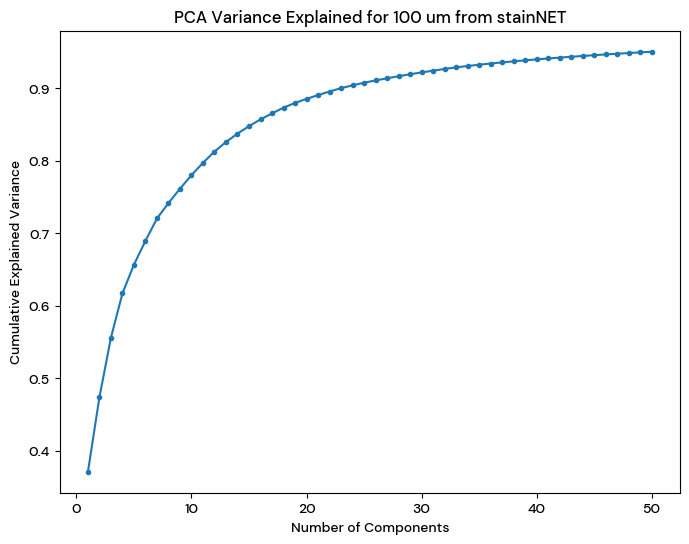

In [57]:
from utils_clust_n_class import pca_cumulative_variance_plot

plot_nowhite = pca_cumulative_variance_plot(without_white_merged_100, normalisation_name, TILE_SIZE)
plot_nowhite.show()

Then let's have a quick visualisation of the PCA, UMAP and tSNE plots.

/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabga

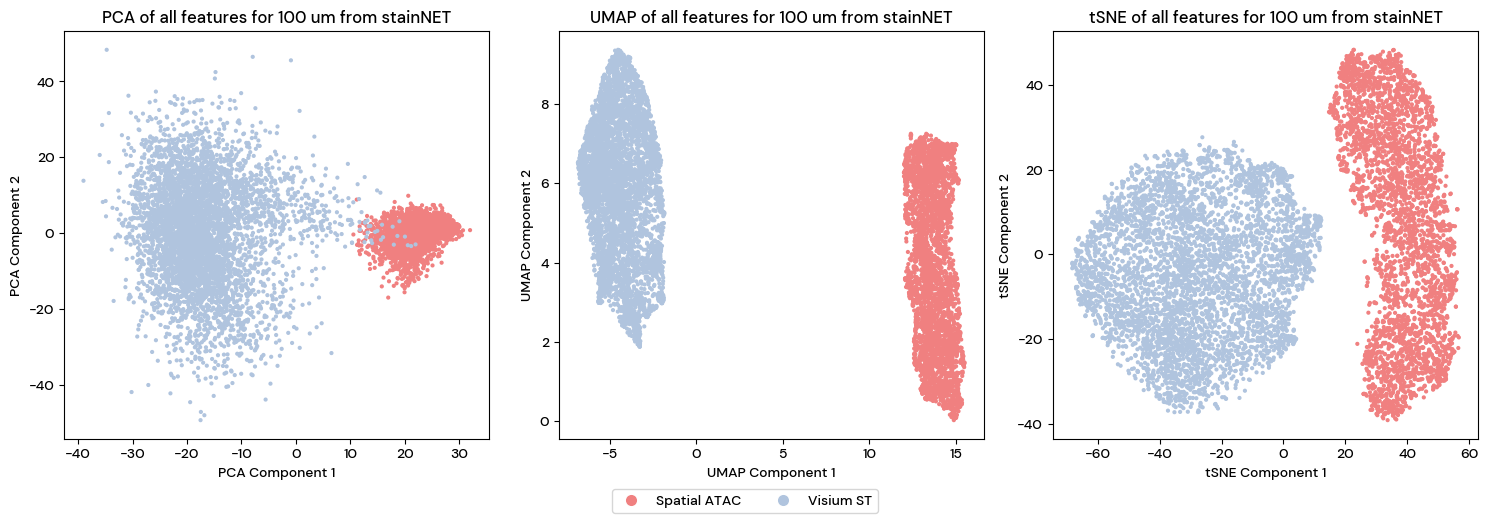

In [58]:
from utils_clust_n_class import all_dim_red

COLORS_FOR_SPATIALS = {"Spatial ATAC": "lightcoral", "Visium ST": "lightsteelblue"}

plot100_nowhite, dim_red_results_100_nowhite =  all_dim_red(without_white_merged_100, normalisation_name, COLORS_FOR_SPATIALS, TILE_SIZE)
plot100_nowhite.show()

In [59]:
# plot100.savefig(os.path.join(PATH_TO_FIGURES, f"plot_all_dimensionality_reductions_{TILE_SIZE}um_{normalisation_name.replace(' ', '_')}.pdf"),
#                 format="PDF", bbox_inches='tight')

So, we can say that the normalisation is necessary.

---

## 2.2 - For 68 μm tiles

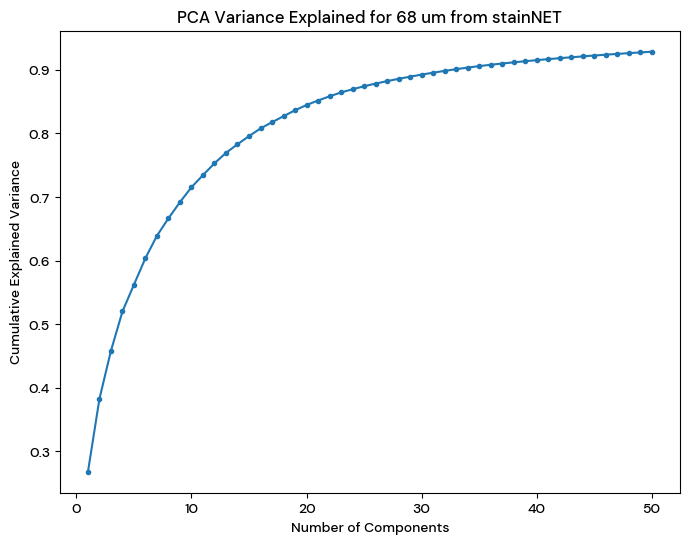

In [60]:
from utils_clust_n_class import pca_cumulative_variance_plot

plot_nowhite = pca_cumulative_variance_plot(without_white_merged_68, normalisation_name, SPOT_SIZE)
plot_nowhite.show()

Then let's have a quick visualisation of the PCA, UMAP and tSNE plots.

/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabga

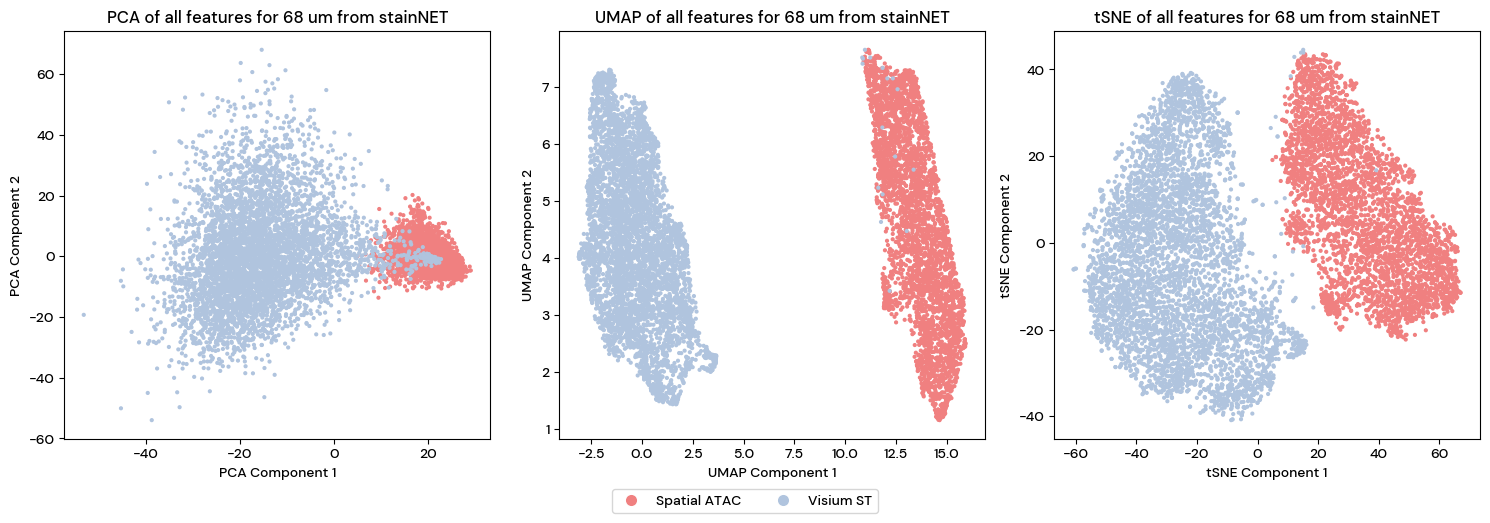

In [61]:
from utils_clust_n_class import all_dim_red

COLORS_FOR_SPATIALS = {"Spatial ATAC": "lightcoral", "Visium ST": "lightsteelblue"}

plot_68_nowhite, dim_red_results_68_nowhite =  all_dim_red(without_white_merged_68, normalisation_name, COLORS_FOR_SPATIALS, SPOT_SIZE)
plot_68_nowhite.show()

In [62]:
# plot_68.savefig(os.path.join(PATH_TO_FIGURES, f"plot_all_dimensionality_reductions_{SPOT_SIZE}um_{normalisation_name.replace(' ', '_')}.pdf"), 
#                 format="PDF", bbox_inches='tight')

# 2. - Dimensionality reduction

Let's plot the cumulative variance explained by the most important components.

## 2.1 - For 100 μm tiles

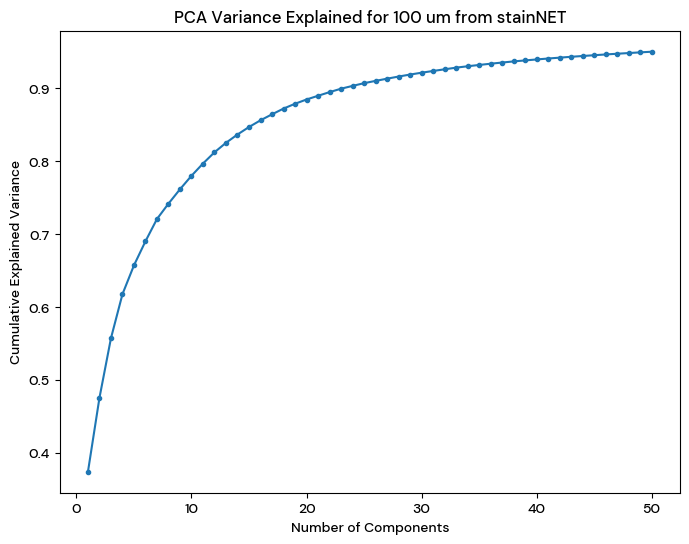

In [63]:
from utils_clust_n_class import pca_cumulative_variance_plot

plot = pca_cumulative_variance_plot(merged_selected_pickle_df_100um, normalisation_name, TILE_SIZE)
plot.show()

Then let's have a quick visualisation of the PCA, UMAP and tSNE plots.

/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabga

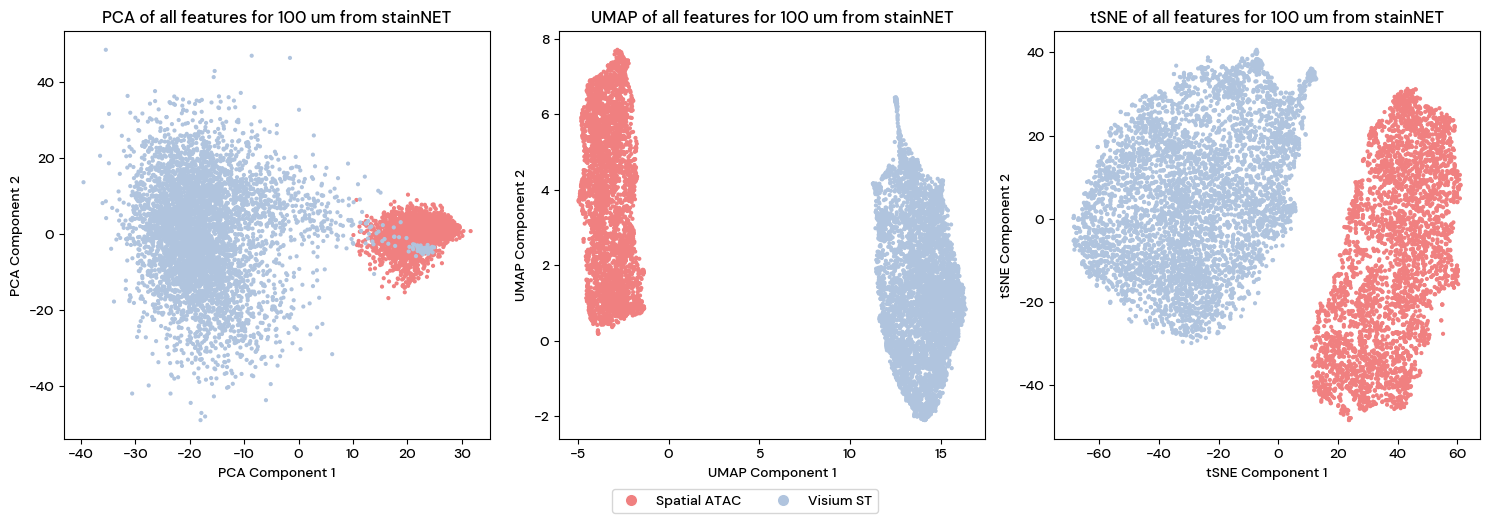

In [64]:
from utils_clust_n_class import all_dim_red

COLORS_FOR_SPATIALS = {"Spatial ATAC": "lightcoral", "Visium ST": "lightsteelblue"}

plot100, dim_red_results_100 =  all_dim_red(merged_selected_pickle_df_100um, normalisation_name, COLORS_FOR_SPATIALS, TILE_SIZE)
plot100.show()

In [65]:
plot100.savefig(os.path.join(PATH_TO_FIGURES, f"plot_all_dimensionality_reductions_{TILE_SIZE}um_{normalisation_name.replace(' ', '_')}.pdf"),
                format="PDF", bbox_inches='tight')

So, we can say that the normalisation is necessary.

---

## 2.2 - For 68 μm tiles

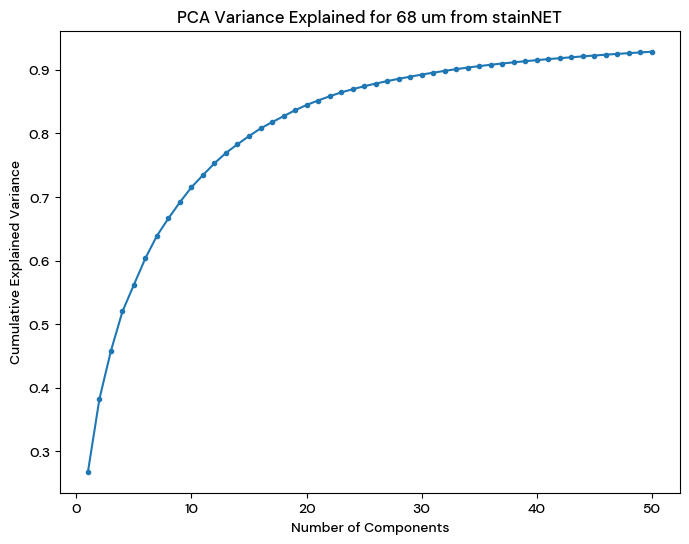

In [66]:
from utils_clust_n_class import pca_cumulative_variance_plot

plot = pca_cumulative_variance_plot(merged_selected_pickle_df_68um, normalisation_name, SPOT_SIZE)
plot.show()

Then let's have a quick visualisation of the PCA, UMAP and tSNE plots.

/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabga

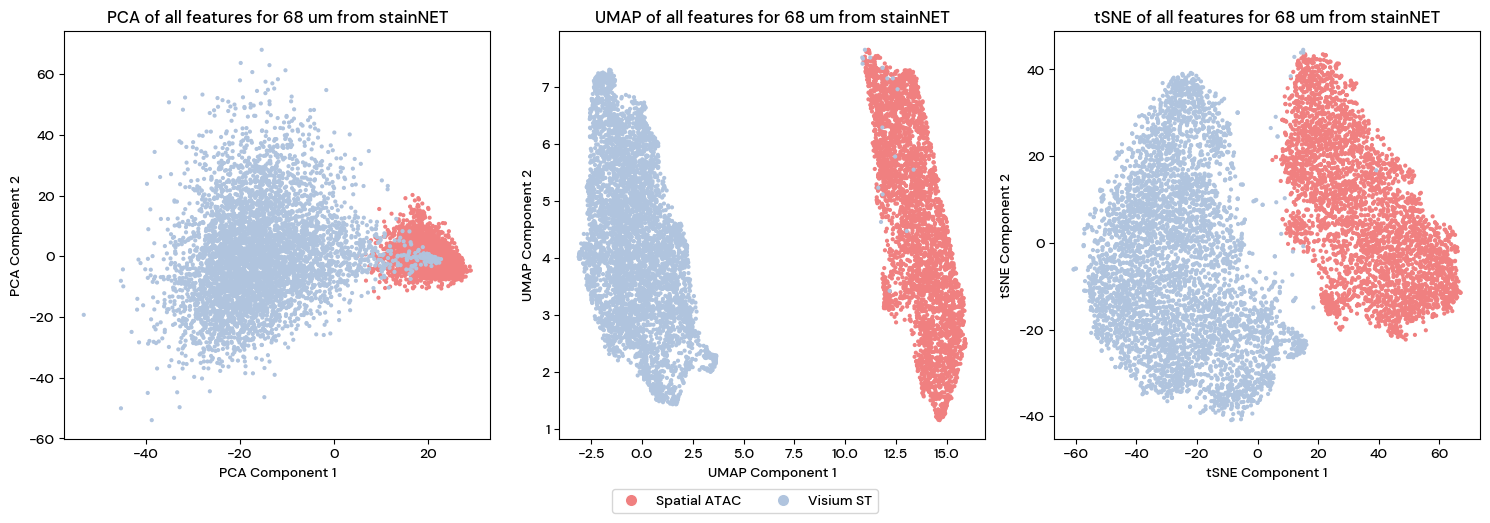

In [67]:
from utils_clust_n_class import all_dim_red

COLORS_FOR_SPATIALS = {"Spatial ATAC": "lightcoral", "Visium ST": "lightsteelblue"}

plot_68, dim_red_results_68 =  all_dim_red(merged_selected_pickle_df_68um, normalisation_name, COLORS_FOR_SPATIALS, SPOT_SIZE)
plot_68.show()

In [68]:
plot_68.savefig(os.path.join(PATH_TO_FIGURES, f"plot_all_dimensionality_reductions_{SPOT_SIZE}um_{normalisation_name.replace(' ', '_')}.pdf"), 
                format="PDF", bbox_inches='tight')